In [23]:
import torch 
# import pandas
import matplotlib.pyplot as plt
import torchvision as vision
from torchvision import datasets, transforms
from matplotlib.patches import Circle
from PIL import Image
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights
print("Testing world")

Testing world


Below is the script to generate the dataset. This dataset originates from the VOC2007 image classification dataset, taking 5011 images as testing images.  
The process of curating the dataset is as follows:
- Take each image and split them 

5011
<PIL.Image.Image image mode=RGB size=480x364 at 0x1B5977015D0>
0


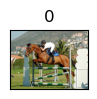

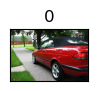

In [5]:


TRAIN_DATA_PATH = "Dataset/VOCdevkit/VOC2007/JPEGImages/"
# transform = transforms.Compose([transforms.Resize(255),
#                                  transforms.CenterCrop(224),
#                                  transforms.ToTensor()])

# transform = transforms.Compose([transforms.Resize(255),
#                                  transforms.CenterCrop(224)])

transform = transforms.Compose([])

train_dataset = datasets.ImageFolder(TRAIN_DATA_PATH, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

print(len(train_dataset))
img, lab = train_dataset[5]
img1, lab1 = train_dataset[1]

print(img)
print(lab)
# images, labels = next(iter(dataloader))
# print(type(images))

# fig = px.imshow(img)
# fig.show()

fig=plt.figure()
fig.set_size_inches(1,1)
p=fig.add_subplot()

p.set_title(str(lab))
p.axes.get_xaxis().set_visible(False)
p.axes.get_yaxis().set_visible(False)
plt.imshow(img)

fig=plt.figure()
fig.set_size_inches(1,1)
p=fig.add_subplot()

p.set_title(str(lab1))
p.axes.get_xaxis().set_visible(False)
p.axes.get_yaxis().set_visible(False)
plt.imshow(img1)


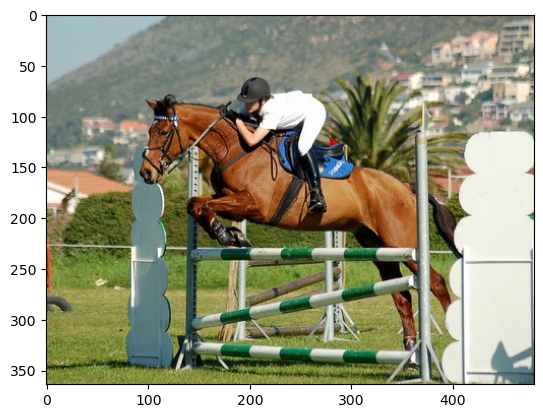

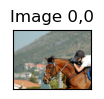

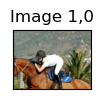

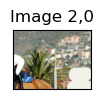

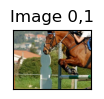

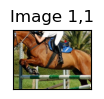

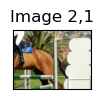

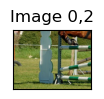

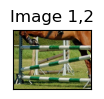

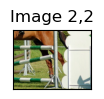

In [35]:
from matplotlib.patches import Circle
from PIL import Image

fig,ax = plt.subplots(1)
ax.set_aspect('equal')

ax.imshow(img)

(x1,y1,x2,y2) = img.getbbox()
gridX = x2 / 4
gridY = y2 / 4

# Method with grids instead
# Creates a 4x4 grid and take 9 2x2 segments as zoomed images 
photoList = []
for b in range (0,3):
    for a in range(0,3):
        xLeft = a*gridX
        xRight = (a+2)*gridX
        yTop = b*gridY
        yBottom = (b+2)*gridY
        im1 = img.crop((xLeft, yTop, xRight, yBottom))

        fig=plt.figure()
        fig.set_size_inches(1,1)
        p=fig.add_subplot()

        title = "Image " + str(a) + "," + str(b)
        p.set_title(title)
        p.axes.get_xaxis().set_visible(False)
        p.axes.get_yaxis().set_visible(False)
        plt.imshow(im1)
        photoList.append(im1)

# for photo in photoList:
#     plt.imshow(photo)
#Create a folder subimage for each image


In [7]:
##Putting these images into AlexNet to determine best one
from torchvision import models

In [8]:
#Downloading the weights for the network
alexnet = models.alexnet(pretrained=True)
alexnet

d:\Programming\programs\miniconda3\envs\Dissertation\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\Programming\programs\miniconda3\envs\Dissertation\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [40]:
transformAlex = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485,0.456,0.406],
        std=[0.229,0.224,0.225]
    )
])

with open('voc_classes.txt') as f:
  classes = [line.strip() for line in f.readlines()]
# print("Number of classes: {}".format(len(classes)))
# classes

photoIndex = 0
# for photo in photoList:
#   photoIndex += 1
#   print(photoIndex)
img_t = transformAlex(photoList[6])
img_t.shape

batch_t = torch.unsqueeze(img_t,0)

alexnet.eval()

out = alexnet(batch_t)
out.shape

_, indices = torch.sort(out, descending=True)
percentage = torch.nn.functional.softmax(out, dim=1)[0] * 100
[(classes[idx], percentage[idx].item()) for idx in indices[0][:10]]





[('harvester, reaper', 12.408656120300293),
 ('plow, plough', 9.104186058044434),
 ('thresher, thrasher, threshing machine', 7.001903533935547),
 ('lawn mower, mower', 6.050253391265869),
 ('bow', 3.918287992477417),
 ('croquet ball', 3.6960620880126953),
 ('bicycle-built-for-two, tandem bicycle, tandem', 2.8682188987731934),
 ('swing', 2.7690558433532715),
 ('tractor', 1.8744053840637207),
 ('golfcart, golf cart', 1.5707393884658813)]

12500
Working
Working
Working
Working
['tiger', 'tiger cat', 'Persian cat', 'Siamese cat', 'Egyptian cat', 'cougar', 'lynx', 'leopard', 'snow leopard', 'jaguar', 'lion', 'cheetah', 'tabby']
0
Egyptian cat: 14.1%
1
Egyptian cat: 7.2%
2
Angora: 15.9%
3
Cardigan: 4.3%
4
Angora: 6.6%
5
Angora: 20.8%
6
Angora: 19.1%
7
Japanese spaniel: 9.7%
8
Samoyed: 14.1%
9
Angora: 9.4%
10
Angora: 20.6%
11
Angora: 29.1%
12
Angora: 19.8%
13
Angora: 20.3%
Top Score  14.11428153514862  Index  0


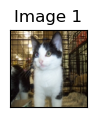

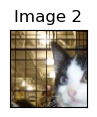

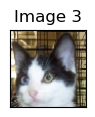

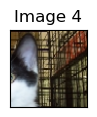

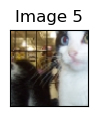

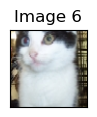

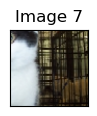

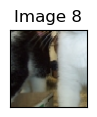

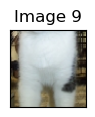

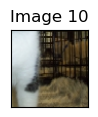

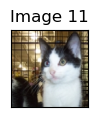

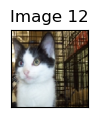

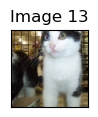

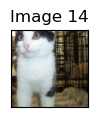

In [35]:
#Getting Cat images
TRAIN_DATA_PATH = "PetImages/CatUnlabelled/"
# transform = transforms.Compose([transforms.Resize(255),
#                                  transforms.CenterCrop(224),
#                                  transforms.ToTensor()])

# transform = transforms.Compose([transforms.Resize(255),
#                                  transforms.CenterCrop(224)])

transform = transforms.Compose([])

train_dataset = datasets.ImageFolder(TRAIN_DATA_PATH, transform=transform)
dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)

print(len(train_dataset))
img, lab = train_dataset[4]
img1, lab1 = train_dataset[1]


def guessImage(img):
    # Step 1: Initialize model with the best available weights
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    model.eval()

    # Step 2: Initialize the inference transforms
    preprocess = weights.transforms()

    # Step 3: Apply inference preprocessing transforms
    batch = preprocess(img).unsqueeze(0)

    # Step 4: Use the model and print the predicted category
    prediction = model(batch).squeeze(0).softmax(0)
    class_id = prediction.argmax().item()
    score = prediction[class_id].item()
    category_name = weights.meta["categories"][class_id]
    print(f"{category_name}: {100 * score:.1f}%")
    return category_name, 100 * score


def splitZooms(dataset):
    (x1,y1,x2,y2) = img.getbbox()
    gridX = x2 / 4
    gridY = y2 / 4


    labelList = []
    zoomList = []
    index = 1
    fig=plt.figure()
    fig.set_size_inches(1,1)
    p=fig.add_subplot()
    title = "Image " + str(index)
    p.set_title(title)
    p.axes.get_xaxis().set_visible(False)
    p.axes.get_yaxis().set_visible(False)
    plt.imshow(img)
    zoomList.append(img)

    # Creating cropped versions of images 
    # Nine 2x2 crips
    for x in range (0,3):
        for y in range(0,3):
            xLeft = y*gridX
            xRight = (y+2)*gridX
            yTop = x*gridY
            yBottom = (x+2)*gridY
            im = img.crop((xLeft, yTop, xRight, yBottom))

            fig=plt.figure()
            fig.set_size_inches(1,1)
            p=fig.add_subplot()
            index += 1
            title = "Image " + str(index)
            p.set_title(title)
            p.axes.get_xaxis().set_visible(False)
            p.axes.get_yaxis().set_visible(False)
            plt.imshow(im)
            zoomList.append(im)
            labelList.append(0)

    # Four 3x3 crops
    for x in range (0,2):
        for y in range(0,2):
            print("Working")
            xLeft = y*gridX
            xRight = (y+3)*gridX
            yTop = x*gridY
            yBottom = (x+3)*gridY
            im = img.crop((xLeft, yTop, xRight, yBottom))

            fig=plt.figure()
            fig.set_size_inches(1,1)
            p=fig.add_subplot()
            index += 1
            title = "Image " + str(index)
            p.set_title(title)
            p.axes.get_xaxis().set_visible(False)
            p.axes.get_yaxis().set_visible(False)
            plt.imshow(im)
            zoomList.append(im)
            labelList.append(0)
    

    # Determining the optimal crop
    dispIndex = 0
    topScore = 0
    topIndex = -1
    with open('cat_labels.txt') as f:
        classes = [line.strip() for line in f.readlines()]
        print(classes)
    for image in zoomList:
        print(dispIndex)
        category_name, score = guessImage(image)
        cat_label = False
        if category_name in classes:
            cat_label = True
        if cat_label and score > topScore:
            topScore = score
            topIndex = dispIndex
        dispIndex += 1
    print("Top Score ", topScore, " Index ", topIndex)
        

splitZooms(train_dataset)

